In [ ]:
"""
This file analyzes how the evolution of the feed position from a rather large 
value to a very small value influences the resonance frequency.

In this code, we do not modify either the meander distance or the width of the meandered track.
"""

"\nCe fichier analyse comment l'evolutin de la position feed d'une valeur assez \ngrandre a une valuer tres petite influence la frequence de raisonnance\n\nDans ce code, On ne touche Ni a la distance meandre ni a la largeur de la piste meandree\n"

In [2]:
from utils.ifa_meander_project_v2.geometry import *
from utils.ifa_meander_project_v2.meshing import *
from utils.ifa_meander_project_v2.frequency import *
from utils.ifa_meander_project_v2.simulation import *

In [ ]:
fLow = 700e6
fHigh = 1000e6
fC = 868e6
step = 4e6

frequencies, fc_index, nPoints = generate_frequencies(fLow, fHigh, fC, step)

print(f"Number of frequencies (nPoints): {nPoints}")
print(f"Index of fC: {fc_index}")

Nombre de fréquences (nPoints) : 76
Index de fC : 42


In [4]:
mesh_name = "ifa_meander_anlyse_3.msh"
save_mesh_folder = 'data/gmsh_files/'
ifa_meander_mat = 'data/antennas_mesh/ifa_meander_anlyse_3.mat'
ifa_meander_msh = save_mesh_folder + mesh_name

In [ ]:
a = 25 / 1000  # Width
b = 45 / 1000  # Height

terminal_a = 55 / 1000
terminal_b = b
x_t = np.array([-terminal_a, 0, 0, -terminal_a])
y_t = np.array([terminal_b, terminal_b, 0, 0])

# Fix the short feed and the track width
largeur_piste    = a / 10
distance_meandre = a / 10

mesh_size = 10 / 1000

In [6]:
feed_list = np.linspace(b - 3 * largeur_piste / 2 - 0.5 / 1000, largeur_piste / 2, 50)
print(f"Feed min: {feed_list[-1] * 1000:.2f} mm")
print(f"Feed max: {feed_list[0] * 1000:.2f} mm")

np.save('data/analyse_feed_position/feed_list.npy', feed_list)

Feed min: 1.25 mm
Feed max: 40.75 mm


In [ ]:
def creation_ifa(largeur, hauteur, width, dist_meandre, feed, x_t, y_t, save_mesh_folder, mesh_name, mesh_size):
    x, y, N, distance_meandre = ifa_creation(largeur, hauteur, width, dist_meandre)
    x_m, y_m = trace_meander(x, y, width)
    feed_wid = width # The track width is the same everywhere
    feed_x = np.array([0, distance_meandre, distance_meandre, 0])
    feed_y = np.array([feed + feed_wid/2, feed + feed_wid/2, feed - feed_wid/2, feed - feed_wid/2])
    antenna_ifa_meander(x_m, y_m, x_t, y_t, feed_x, feed_y, save_mesh_folder, mesh_name, mesh_size)
    extract_msh_to_mat(ifa_meander_msh, ifa_meander_mat)
    return N, distance_meandre

def plot_s11_curve(fLow, fHigh, nPoints, s11_db, fC=None):
    from matplotlib import pyplot as plt
    frequencies = np.linspace(fLow, fHigh, nPoints)
    frequencies_mhz = np.array(frequencies) / 1e6
    s11_db = np.array(s11_db)

    # Find the minimum of S11
    min_index = np.argmin(s11_db)
    f_resonance = frequencies[min_index] / 1e6
    s11_min = s11_db[min_index]

    # Plot
    fig_size = 7
    Fibonacci = (1 + np.sqrt(5)) / 2
    plt.figure(figsize=(fig_size, fig_size / Fibonacci))
    plt.plot(frequencies_mhz, s11_db, label="S11 (dB)", color='blue')
    plt.plot(f_resonance, s11_min, 'ro', 
            label=f"Resonance: {f_resonance:.2f} MHz (S11={s11_min:.2f} dB)")
    
    if fC:
        fC_mhz = fC / 1e6
        idx_fc = np.argmin(np.abs(frequencies - fC))
        s11_fc = s11_db[idx_fc]
        plt.axvline(fC_mhz, color='green', linestyle='--', 
                   label=f"fC = {fC_mhz:.2f} MHz (S11={s11_fc:.2f} dB)")

    plt.xlabel("Frequency (MHz)")
    plt.ylabel("S11 (dB)")
    plt.title("S11 vs Frequency curve")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
iteration = 1
frequences_resonance = []
for feed in feed_list:
    try:
        print(f"\n------------------------------------------------------Iteration N°{iteration}------------------------------------------------------")
        print(f"Meander distance {distance_meandre * 1000} mm")
        print(f"IFA track width {largeur_piste * 1000} mm")
        print(f"Feed position = {feed * 1000} mm\n")
        N_list_elem, new_distance_meandre_elem = creation_ifa(a, b, largeur_piste, distance_meandre, feed, x_t, y_t, save_mesh_folder, mesh_name, mesh_size)
        print(f"Number of meanders {N_list_elem}")
        print(f"New meander distance {new_distance_meandre_elem * 1000} mm")
        feed_point = [0, feed, 0]
        frequence_resonance, s11_db = analysis(frequencies, ifa_meander_mat, feed_point)
        frequences_resonance.append(frequence_resonance)
        if frequence_resonance == fC:
            plot_s11_curve(fLow, fHigh, nPoints, s11_db, fC)

        iteration += 1
    except ValueError as e:
        print(f"Error: {e}")

np.save(f'data/analyse_feed_position/frequences_resonance.npy', frequences_resonance)


------------------------------------------------------Iteration N°1------------------------------------------------------
distance meandres 2.5 mm
Largeur de piste ifa 2.5 mm
position feed = 40.74999999999999 mm

Number of meanders 5
New distance meandres 2.5 mm
Simulation 1/76 | f = 700.00 MHz | S11 = -0.59 dB
Simulation 2/76 | f = 704.00 MHz | S11 = -0.49 dB
Simulation 3/76 | f = 708.00 MHz | S11 = -0.42 dB
Simulation 4/76 | f = 712.00 MHz | S11 = -0.36 dB
Simulation 5/76 | f = 716.00 MHz | S11 = -0.31 dB
Simulation 6/76 | f = 720.00 MHz | S11 = -0.27 dB
Simulation 7/76 | f = 724.00 MHz | S11 = -0.24 dB
Simulation 8/76 | f = 728.00 MHz | S11 = -0.22 dB
Simulation 9/76 | f = 732.00 MHz | S11 = -0.20 dB
Simulation 10/76 | f = 736.00 MHz | S11 = -0.18 dB
Simulation 11/76 | f = 740.00 MHz | S11 = -0.16 dB
Simulation 12/76 | f = 744.00 MHz | S11 = -0.15 dB
Simulation 13/76 | f = 748.00 MHz | S11 = -0.14 dB
Simulation 14/76 | f = 752.00 MHz | S11 = -0.13 dB
Simulation 15/76 | f = 756.00 M

In [ ]:
# Load and display feed_list.npy
loaded_feed_list = np.load('data/analyse_feed_position/feed_list.npy')
print("\nContents of loaded_feed_list.npy:", loaded_feed_list / b * 100)

# Load and display frequences_resonance.npy
loaded_frequences_resonance = np.load('data/analyse_feed_position/frequences_resonance.npy')
print("\nContents of frequences_resonance.npy:", loaded_frequences_resonance * 1e-6)


Contenu de loaded_largeur_piste_list.npy : [90.55555556 88.76417234 86.97278912 85.1814059  83.39002268 81.59863946
 79.80725624 78.01587302 76.2244898  74.43310658 72.64172336 70.85034014
 69.05895692 67.2675737  65.47619048 63.68480726 61.89342404 60.10204082
 58.3106576  56.51927438 54.72789116 52.93650794 51.14512472 49.3537415
 47.56235828 45.77097506 43.97959184 42.18820862 40.3968254  38.60544218
 36.81405896 35.02267574 33.23129252 31.4399093  29.64852608 27.85714286
 26.06575964 24.27437642 22.4829932  20.69160998 18.90022676 17.10884354
 15.31746032 13.5260771  11.73469388  9.94331066  8.15192744  6.36054422
  4.569161    2.77777778]

Contenu de frequences_resonance.npy : [700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700.
 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 704. 708. 708.
 708. 708. 708. 708. 712. 712. 716. 716. 716. 720. 720. 720. 724. 724.
 724. 724. 724. 728. 728. 728. 728. 728.]


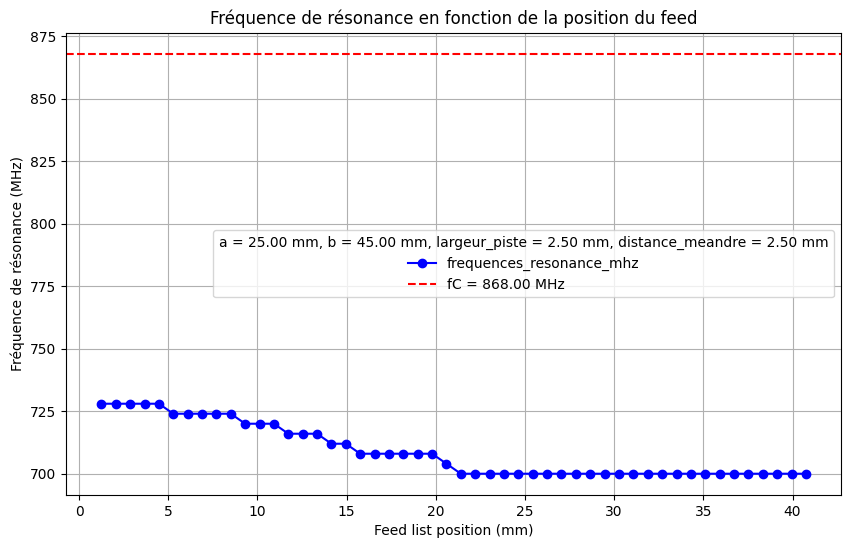

In [ ]:
from matplotlib import pyplot as plt

# Convert data
frequences_resonance_mhz = np.array(loaded_frequences_resonance) * 1e-6
loaded_feed_list_mm = np.array(loaded_feed_list) * 1000  # Convert to mm

plt.figure(figsize=(10, 6))
plt.plot(loaded_feed_list_mm, frequences_resonance_mhz, marker='o', linestyle='-', color='b', label='frequences_resonance_mhz')

# Add a horizontal line for fC
plt.axhline(y=fC * 1e-6, color='r', linestyle='--', label=f'fC = {fC * 1e-6:.2f} MHz')

plt.xlabel('Feed list position (mm)')
plt.ylabel('Resonance frequency (MHz)')
plt.title('Resonance frequency as a function of feed position')
plt.legend(title=f"a = {a * 1000:.2f} mm, b = {b * 1000:.2f} mm, track width = {largeur_piste * 1000:.2f} mm, meander distance = {distance_meandre * 1000:.2f} mm")
plt.grid(True)
plt.show()